# CV Project - Face Recognition

## The Problem Description: 

The goal is to build a face identification model to recognize faces.

## Data Description:
This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. 

## Objective: 

In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not. 

## Steps and Tasks: 
● Load the dataset and create the metadata. 

● Check some samples of metadata. ● Load the pre-trained model and weights. 

● Generate Embedding vectors for each face in the dataset.

● Build distance metrics for identifying the distance between 
two given images. 

● Use PCA for dimensionality reduction. 

● Build SVM classifier to map each image to its right person. 

● Predict using the SVM model. 

### Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder

In [6]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Face Recognition Model')
path = '.'

### Loading the Libraries

In [7]:
from __future__ import absolute_import
from __future__ import print_function
import os
import time
from datetime import timedelta
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import keras
import keras.callbacks
from keras.callbacks import TensorBoard
import pandas.util.testing as tm
import numpy as np
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from sklearn.decomposition import PCA
import pandas.util.testing as tm

### Importing the ZIP file and extracting the images

In [9]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/Colab Notebooks/Face Recognition Model/Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()
  path = "/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS"

In [10]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner58_1668.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner59_1653.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner5_1638.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner60_1650.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner61_1725.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner62_1698.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner64_1722.jpg
/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_Sophie Turner/Sophie Turner65_1682.jpg
/content/drive

### Load the Images

Define a fuction to load the images

In [11]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    dir_list = os.listdir(path)
    print("Files and directories in '", path, "' :")  
# print the list 
    print(dir_list) 

    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

Files and directories in ' PINS ' :
['pins_Aaron Paul', 'pins_Alvaro Morte', 'pins_Amanda Crew', 'pins_Amaury Nolasco', 'pins_Anna Gunn', 'pins_Benedict Cumberbatch', 'pins_Betsy Brandt', 'pins_Brenton Thwaites', 'pins_Brit Marling', 'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan', 'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Cobie Smulders', 'pins_Danielle Panabaker', 'pins_Dave Franco', 'pins_Dominic Purcell', 'pins_Dwayne Johnson', 'pins_Emilia Clarke', 'pins_Emily Bett Rickards', 'pins_Emma Stone', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil', 'pins_Jason Momoa', 'pins_Jeremy Renner', 'pins_Jesse Eisenberg', 'pins_Jim Parsons', 'pins_Jon Bernthal', 'pins_Josh Radnor', 'pins_Kit Harington', 'pins_Krysten Ritter', 'pins_Kumail Nanjiani', 'pins_Maisie Williams', 'pins_Mark Ruffalo', 'pins_Martin Starr', 'pins_Melissa benoit', 'pins_Mike Colter', 'pins_Morena Baccarin', 'pins_Morgan Freeman', 'pins_Natalie Portman ', 'pins_Neil Patrick Harris', '

### Define to load an image

In [12]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

### Load a sample image

In [13]:
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

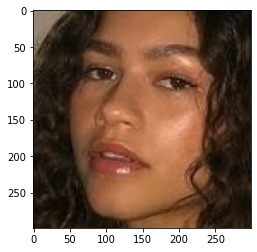

In [14]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('/content/drive/My Drive/Colab Notebooks/Face Recognition Model/pins/PINS/pins_zendaya/zendaya99.jpg') 
  
# Output Images 
plt.imshow(img)

### VGG Face Recognition Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### Loading the model

In [16]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('/content/drive/My Drive/Colab Notebooks/Face Recognition Model/vgg_face_weights.h5')

### Getting the VGG face descriptor

In [17]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generating embeddings for each image in the dataset

### Generating Embedding for One Image

In [18]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generating Embedding for All Images

In [19]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
      
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

### Calculating distance between given 2 pairs of images

In [20]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### Plotting images and geting distance between the pairs given below

2, 3 and 2, 180

30, 31 and 30, 100

70, 72 and 70, 115

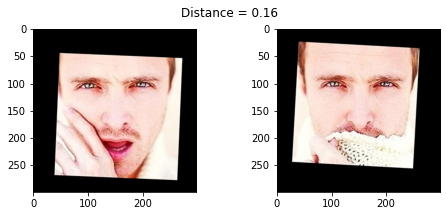

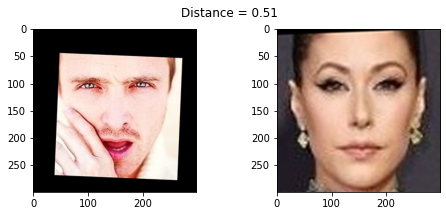

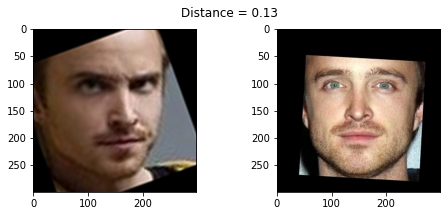

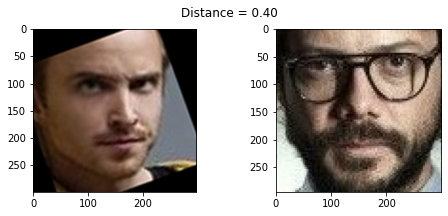

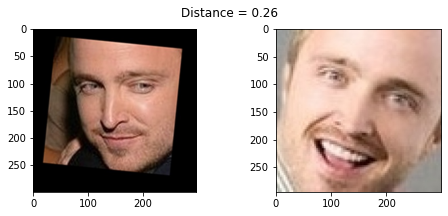

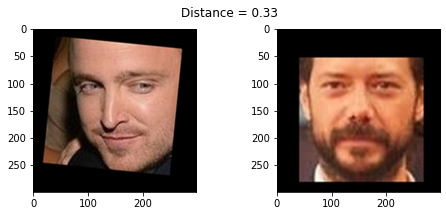

In [24]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path())); 

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets

Create X_train, X_test and y_train, y_test

Use train_idx to seperate out training features and labels

Use test_idx to seperate out testing features and labels

In [25]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

### Encode the Labels

Encode the targets

Use LabelEncoder

In [26]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### Standardize the feature values

Scale the features using StandardScaler

In [27]:
# Standarize features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Reduce dimensions using PCA


In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Build a Classifier Model

Use SVM Classifier to predict the person in the given image

Fit the classifier and print the score

In [29]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9598997493734336

### Test results

Take 10th image from test set and plot the image

Report to which person(folder name in dataset) the image belongs to

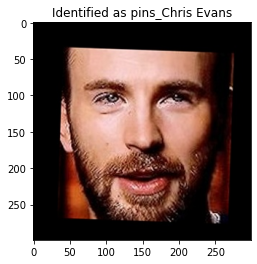

In [39]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 150

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = clf.predict([X_test[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

Conclusion

We built a VGG face recognition model, plotted the images and calculated the dictance between them. We reduced the dimensions using PCA. We built an SVM classifier model with a prediction accuracy of 96%. The model was suceesfully able to identify the image with the name of the celebrity.